# Recommendation Model. Pandas Version. 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors

from pathlib import Path
import os

import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis (15 Pts)
- Gain an understanding of the dataset's structure, contents, and distributions.
- Identify patterns, anomalies, or interesting correlations between different variables, such as user ratings and movie genres.

#### Read the data

Data can be located either in "*part_2_data*" folder or downloaded from *S3 Bucket*

In [29]:
dfs_dict = {}
path_to_data_2 = Path('part_2_data')
if path_to_data_2.exists():
    for _, _, file_names in os.walk(str(path_to_data_2)):
        for file in sorted(file_names):
            if '.csv' in file:
                name = file[:-4].strip().replace('-', '_').lower()
                dfs_dict[name] = pd.read_csv(path_to_data_2 / file)
else:
    url = 'https://kosokolovskiy-my-data-for-projects.s3.eu-central-1.amazonaws.com/'
    doc_names = ['genome-tags.csv', 'genome-scores.csv', 'tags.csv', 'links.csv', 'movies.csv', 'ratings.csv']
    for file in sorted(doc_names):
        if '.csv' in file:
            name = file[:-4].strip().replace('-', '_').lower()
            print(f'Processing: {name}')
            dfs_dict[name] = pd.read_csv(url + file)
   

Processing: genome_scores
Processing: genome_tags
Processing: links
Processing: movies
Processing: ratings
Processing: tags


#### Explore the size of each of documents

In [30]:
for df_name, df in dfs_dict.items():
    print(f'{df_name:<14}: {len(df)}')

genome_scores : 15584448
genome_tags   : 1128
links         : 62423
movies        : 62423
ratings       : 25000095
tags          : 1093360


##### First Look at each of Table

In [31]:
dfs_dict['movies'].head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [32]:
dfs_dict['ratings'].head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [33]:
dfs_dict['genome_scores'].head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [34]:
dfs_dict['genome_tags'].head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [35]:
dfs_dict['links'].head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [36]:
dfs_dict['tags'].head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


#### Extraction of Useful Information / Dataframes Merge

It is definitely and useful to know how many unique samples do we have. In our case the most interesting can be number of unqiue *Movies*, *Users*, *Tags*, *Genres*, range of *Ratings*

In [37]:
n_movies, n_movies_rated = dfs_dict['movies']['movieId'].nunique(), dfs_dict['ratings']['movieId'].nunique()
print(f'Number of movies: {n_movies:>17}')
print(f'Number of movies with rating: {n_movies_rated}')

Number of movies:             62423
Number of movies with rating: 59047


In [38]:
n_users = dfs_dict['ratings']['userId'].nunique()
print(f'Number of unique users: {n_users}')

Number of unique users: 162541


Create df with *mean* rating and *count* - the number of ratings per user. Sort part is not mandatory, but interesting to observe in different directions.

In [39]:
df_user_mean_count = dfs_dict['ratings'].groupby('userId').agg({'rating': ['mean', 'count']}).sort_values(by=[('rating', 'mean'), ('rating', 'count')], ascending=[False, False])
df_user_mean_count

rating      
         mean count
userId             
75309     5.0  5525
12002     5.0   677
99091     5.0   262
159290    5.0   250
35589     5.0   219
...       ...   ...
63044     0.5    20
86408     0.5    20
94280     0.5    20
113767    0.5    20
122697    0.5    20

[162541 rows x 2 columns]

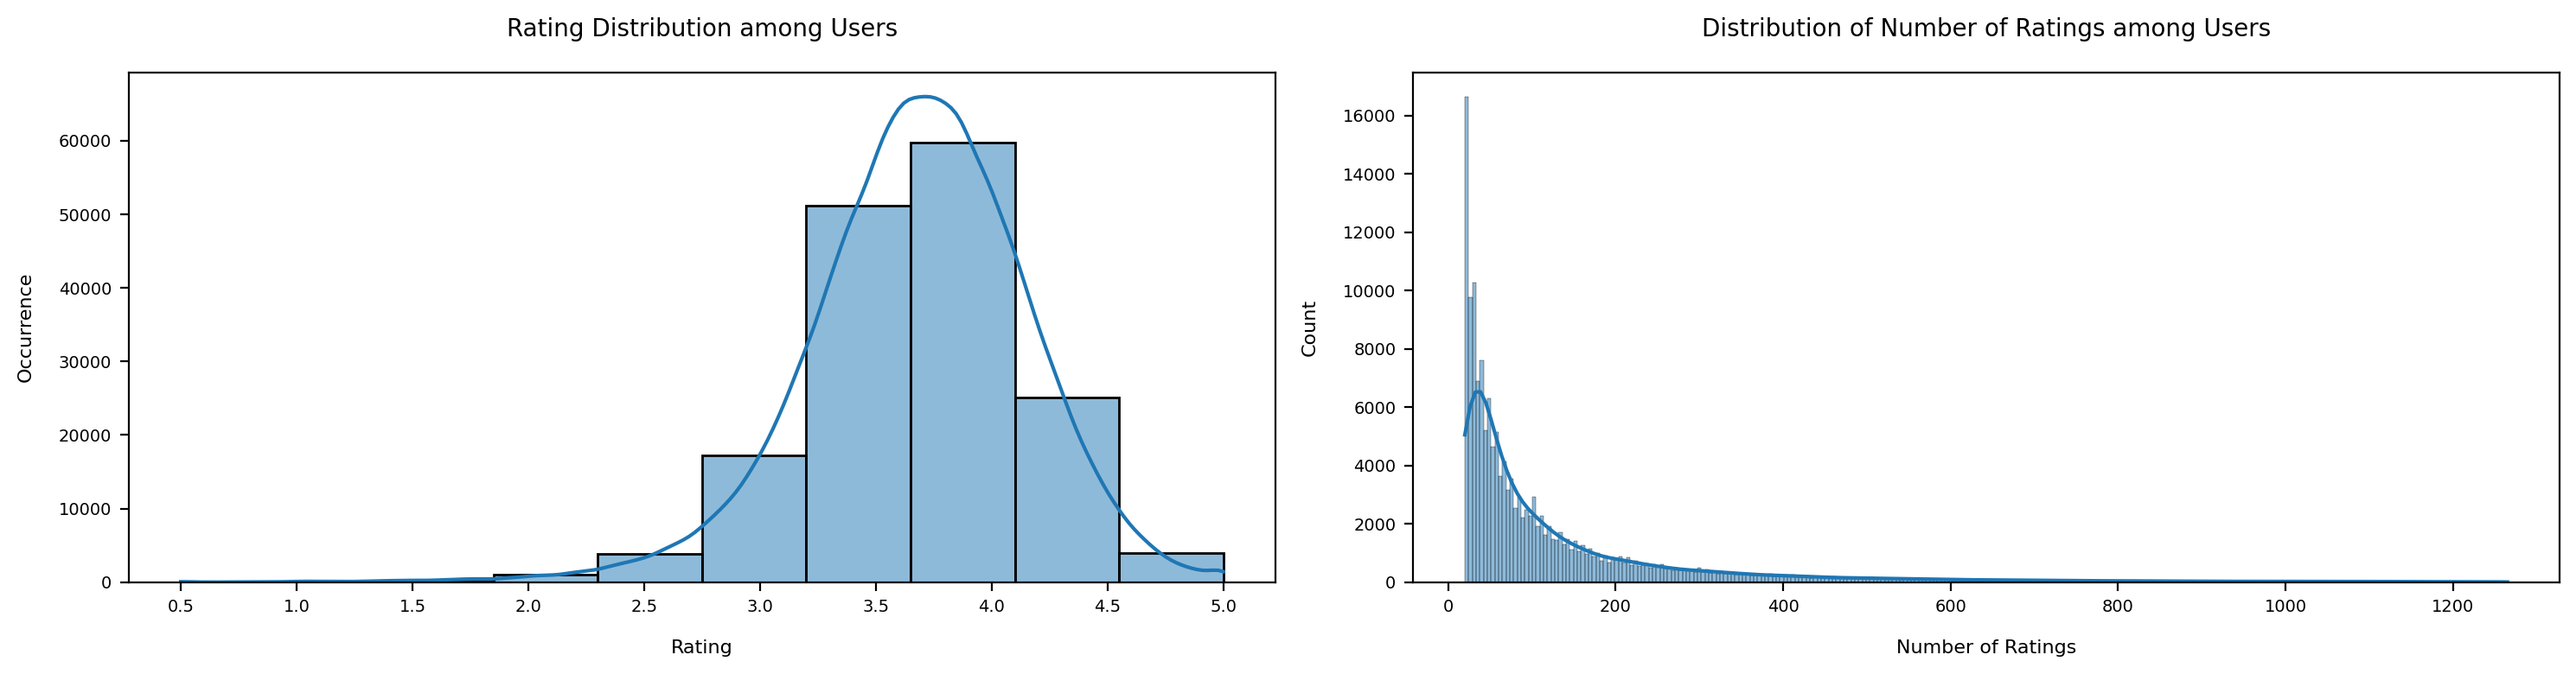

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
sns.histplot(x=df_user_mean_count[('rating', 'mean')], kde=True, bins=len(np.arange(0.5, 5.5, 0.5)), ax=ax[0])
ax[0].set_title('Rating Distribution among Users', pad=15, fontsize=10)
ax[0].set_xticks(np.arange(0.5, 5.5, 0.5))
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=7)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=7)
ax[0].set_xlabel('Rating', fontsize=8, labelpad=10);
ax[0].set_ylabel('Occurrence', fontsize=8, labelpad=10);

# threshold is hard coded to see the real distribution except *too active* movier critics
sns.histplot(x=df_user_mean_count[('rating', 'count')].sort_values()[:-1500], kde=True, ax=ax[1])
ax[1].set_title('Distribution of Number of Ratings among Users', pad=15, fontsize=10)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=7)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=7)
ax[1].set_xlabel('Number of Ratings', fontsize=8, labelpad=10);
ax[1].set_ylabel('Count', fontsize=8, labelpad=10);

plt.tight_layout()

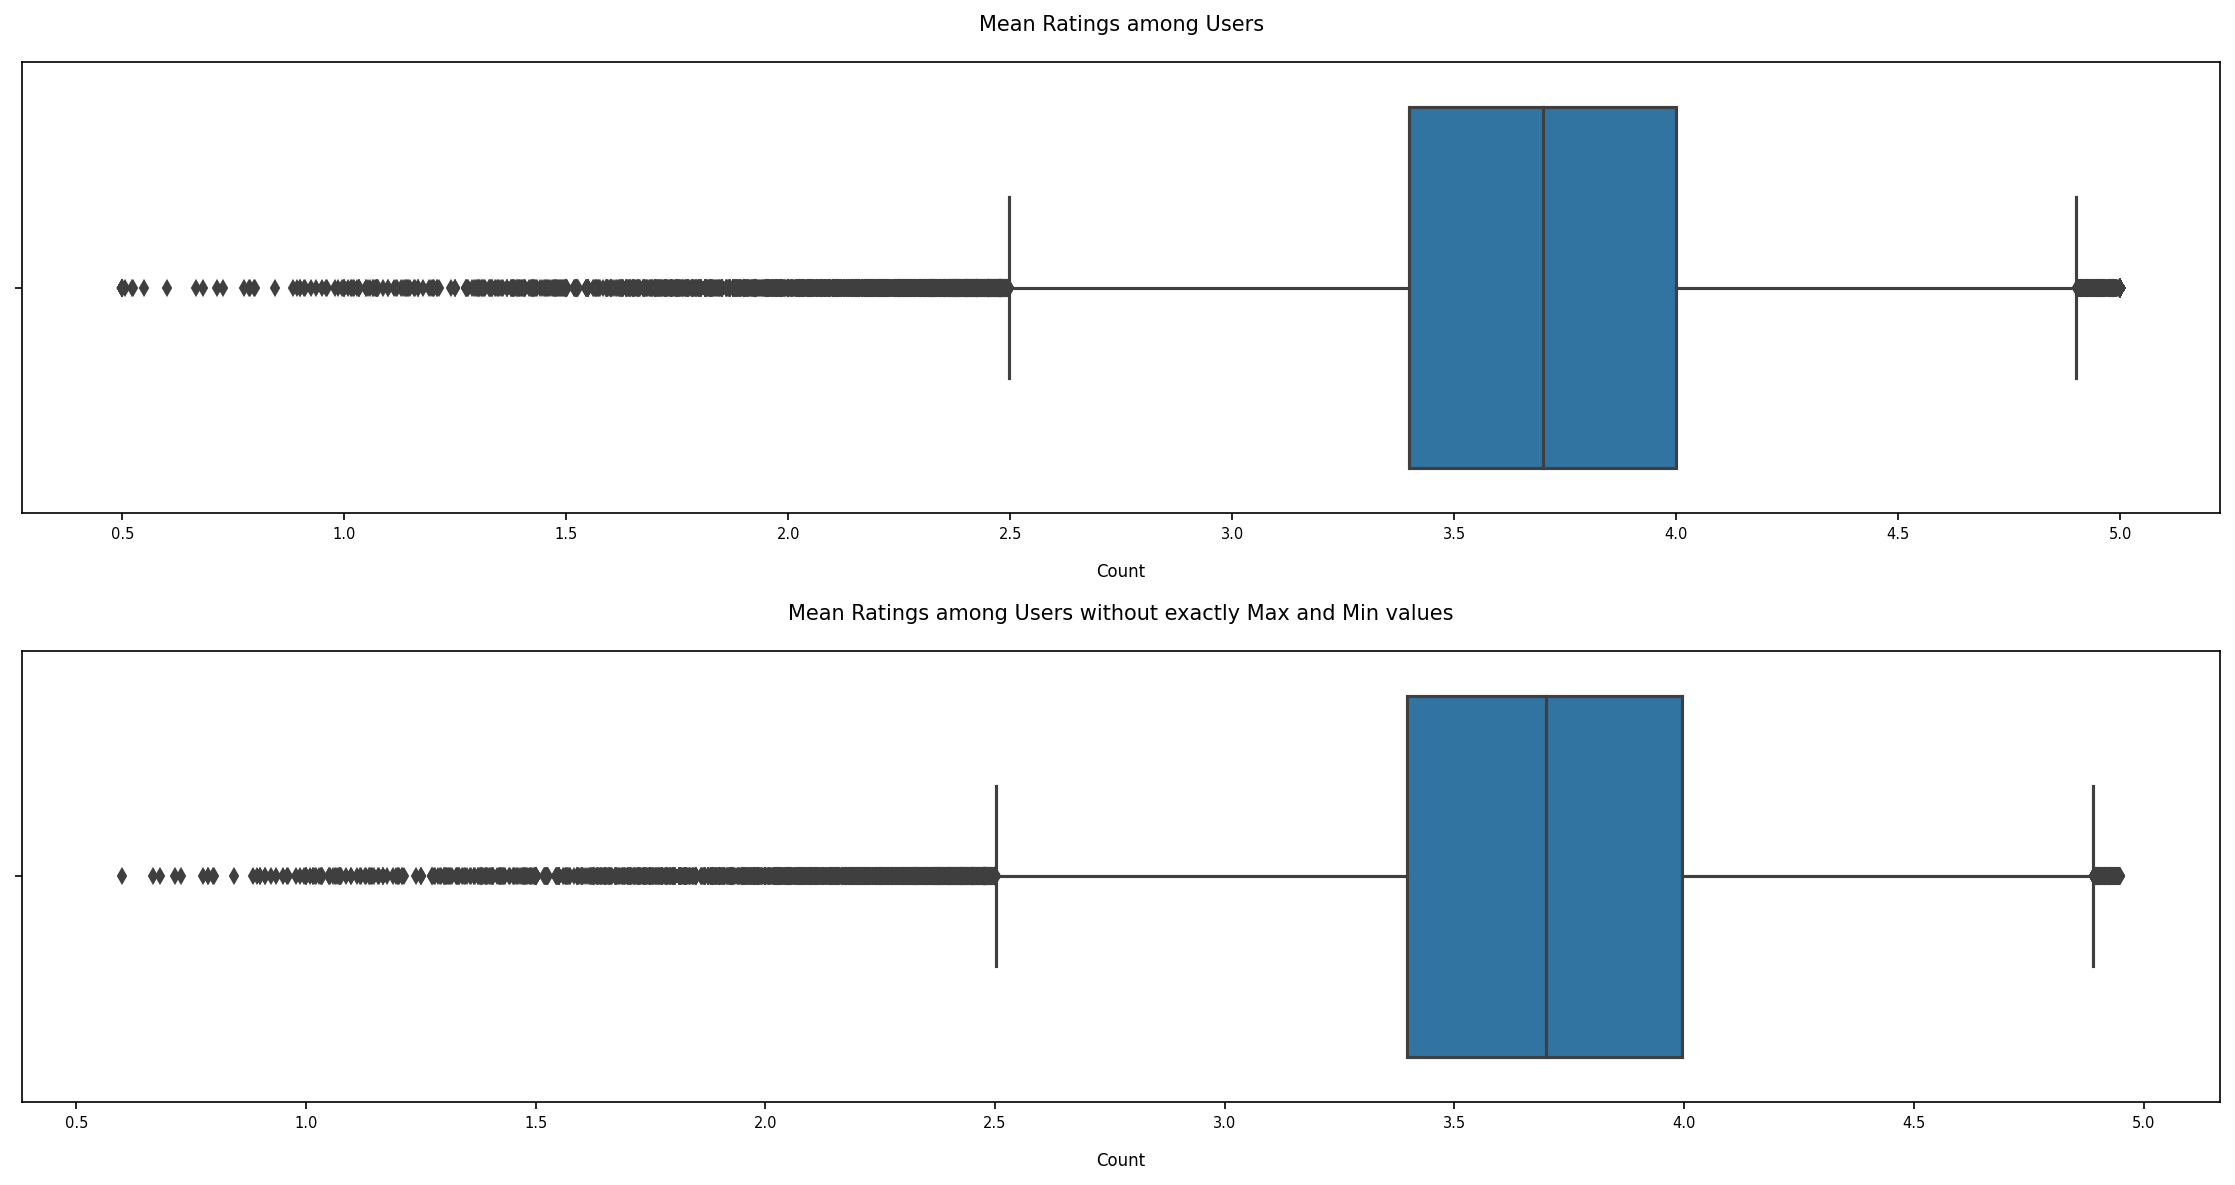

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), dpi=150)

sns.boxplot(x=df_user_mean_count[('rating', 'mean')],  orient='v', ax=ax[0])
ax[0].set_title("Mean Ratings among Users", pad=15, fontsize=10)
ax[0].set_xticks(np.arange(0.5, 5.5, 0.5))
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=7)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=7)
ax[0].set_xlabel('Count', fontsize=8, labelpad=10);

# in case the average rating is equal to maximum or minimal possible, we exclude it
lower_threshold_rating, upper_threshold_rating = [0.55, 4.95]
temp = df_user_mean_count[(df_user_mean_count[('rating', 'mean')] > lower_threshold_rating) &
                          (df_user_mean_count[('rating', 'mean')] < upper_threshold_rating)]
sns.boxplot(x=temp[('rating', 'mean')],  orient='v', ax=ax[1])
ax[1].set_title(
    'Mean Ratings among Users without exactly Max and Min values',
    pad=15,
    fontsize=10,
)
ax[1].set_xticks(np.arange(0.5, 5.5, 0.5))
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=7)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=7)
ax[1].set_xlabel('Count', fontsize=8, labelpad=10);

plt.tight_layout()

No significant changes in the distribution were observed. However, an approach where not only the maximum and minimum values are excluded but also those within a certain threshold, for example, 0.5 units above, is feasible.

##### Timestamps Research

In [42]:
dfs_dict['ratings']['timestamp'] = pd.to_datetime(dfs_dict['ratings']['timestamp'], unit='s')
dfs_dict['ratings'][dfs_dict['ratings']['userId'] == 75309]

,userId,movieId,rating,timestamp
11611247,75309,111,5.0,2019-05-24 22:46:44
11611248,75309,260,5.0,2019-05-24 22:46:44
11611249,75309,750,5.0,2019-05-24 22:46:38
11611250,75309,858,5.0,2019-05-24 22:46:41
11611251,75309,901,5.0,2019-05-24 22:46:37
...,...,...,...,...
11616767,75309,202265,5.0,2019-05-24 22:49:02
11616768,75309,202281,5.0,2019-05-24 22:49:20
11616769,75309,202355,5.0,2019-05-24 22:51:54
11616770,75309,202403,5.0,2019-05-24 22:51:55


In [43]:
dfs_dict['ratings'][dfs_dict['ratings']['userId'] == 75309]['timestamp'].min(), dfs_dict['ratings'][dfs_dict['ratings']['userId'] == 75309]['timestamp'].max()

(Timestamp('2019-05-24 22:46:35'), Timestamp('2019-05-24 22:51:59'))

In a turn of events, a user identified by the ID 75309 has remarkably rated 5,525 movies, each with a perfect score of 5.0, all within a single day—and and within a mere 5-minute window. This extraordinary occurrence raises merits further investigation. It prompts us to delve deeper and question whether this is an isolated anomaly or a recurring pattern within the dataset. Such an unusual burst of activity in an improbably short timeframe suggests the potential for underlying irregularities, making it prudent to scrutinize the dataset for similar instances or to consider the implications of this behavior on data integrity and analysis outcomes.

In [44]:
user_id_sample = 98
dfs_dict['ratings'][dfs_dict['ratings']['userId'] == user_id_sample]['timestamp'].min(), dfs_dict['ratings'][dfs_dict['ratings']['userId'] == user_id_sample]['timestamp'].max(), dfs_dict['ratings'][dfs_dict['ratings']['userId'] == user_id_sample]['timestamp'].max() - dfs_dict['ratings'][dfs_dict['ratings']['userId'] == user_id_sample]['timestamp'].min()

(Timestamp('2015-12-13 22:44:07'),
 Timestamp('2015-12-13 23:07:17'),
 Timedelta('0 days 00:23:10'))

In [45]:
df_delta_time = dfs_dict['ratings'].groupby('userId').agg(
    count_ratings=('timestamp', 'count'),
    min_timestamp=('timestamp', 'min'),
    max_timestamp=('timestamp', 'max')
)
df_delta_time['diff'] = df_delta_time['max_timestamp'] - df_delta_time['min_timestamp']
df_delta_time.sort_values(by=['diff', 'count_ratings'], ascending=[True, False])[-10000:]

,count_ratings,min_timestamp,max_timestamp,diff
userId,,,,
25770,126,2016-01-27 13:41:45,2019-01-23 20:21:08,1092 days 06:39:23
42329,652,1997-12-22 14:39:26,2000-12-18 21:42:53,1092 days 07:03:27
119580,208,2016-10-01 20:05:58,2019-09-29 07:10:15,1092 days 11:04:17
104870,203,2001-02-05 05:50:07,2004-02-02 22:52:04,1092 days 17:01:57
109594,184,2015-11-10 15:54:20,2018-11-07 13:58:06,1092 days 22:03:46
...,...,...,...,...
121934,355,1997-10-04 19:56:37,2019-10-15 18:19:14,8045 days 22:22:37
62383,1292,1997-10-19 00:27:11,2019-11-20 23:02:41,8067 days 22:35:30
107681,944,1997-09-16 16:01:19,2019-10-20 15:42:19,8068 days 23:41:00


Here I want to set a threshold to exclude from observations the users who made all their rates inside less than *threshold* period of time. First suggestion is *1 day*.

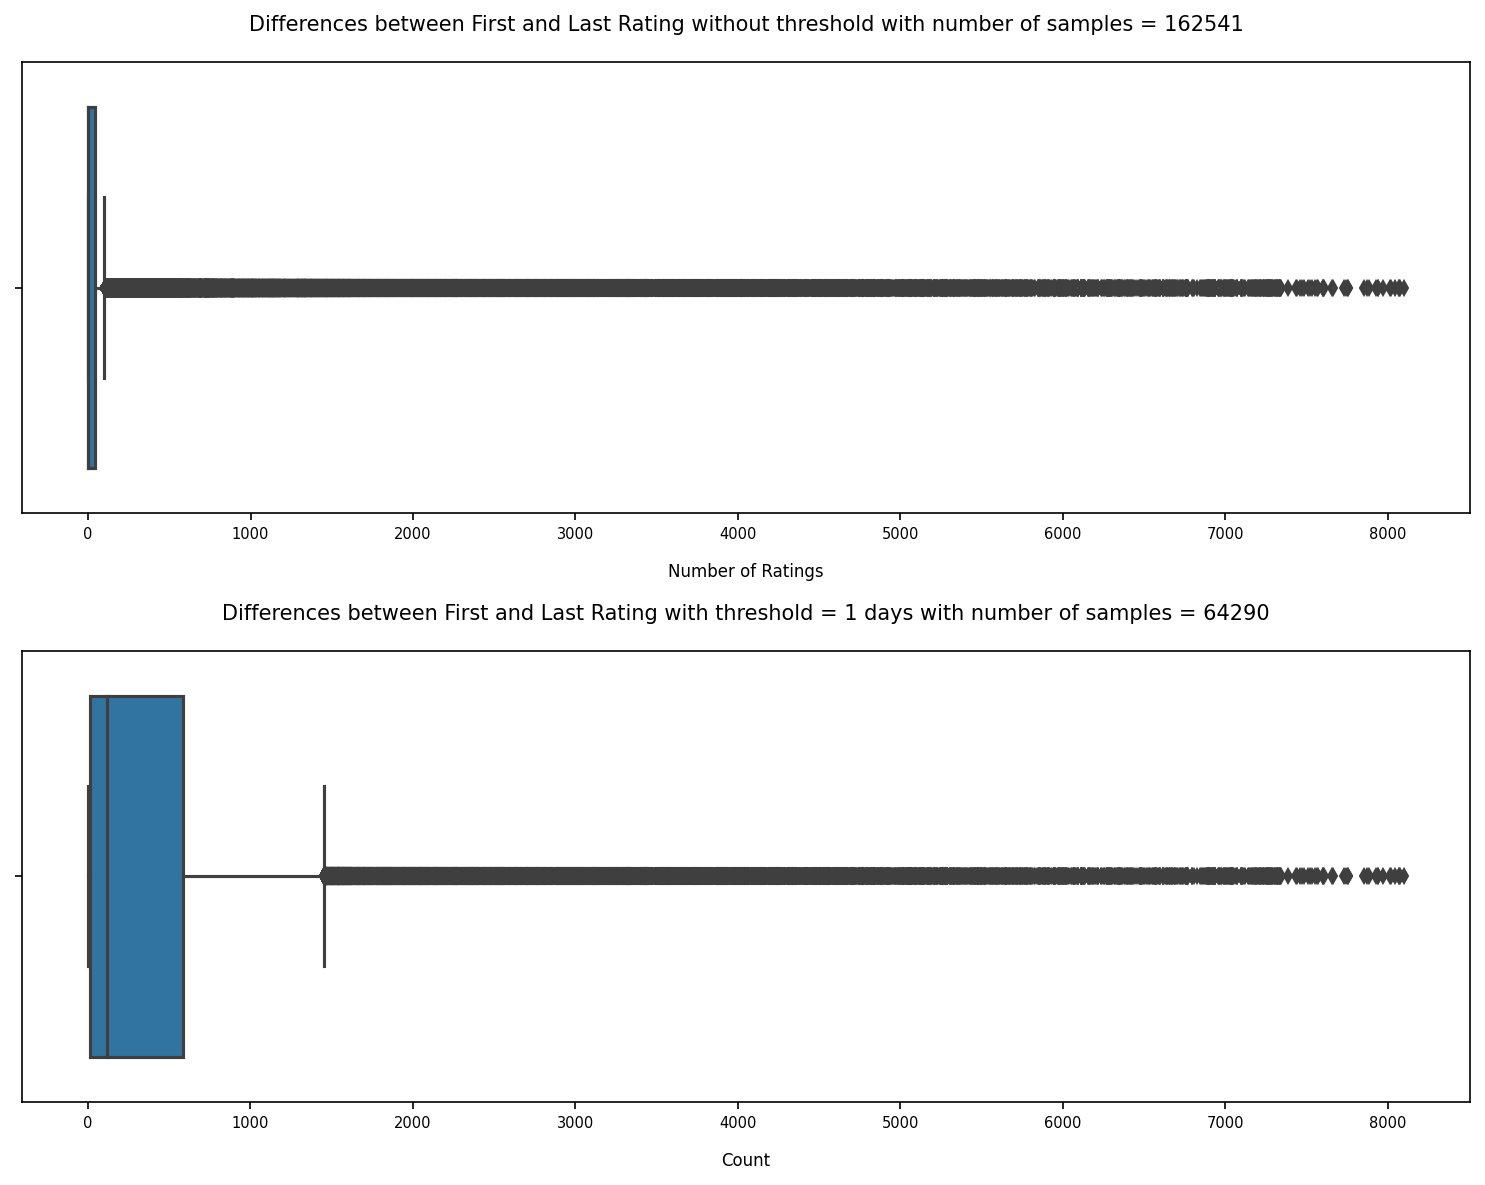

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), dpi=150)

sns.boxplot(x=df_delta_time['diff'].dt.days,  orient='v', ax=ax[0])
ax[0].set_title(f"Differences between First and Last Rating without threshold with number of samples = {len(df_delta_time['diff'].dt.days)}", pad=15, fontsize=10)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=7)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=7)
ax[0].set_xlabel('Number of Ratings', fontsize=8, labelpad=10);


threshold_days_diff = 1
temp = df_delta_time[df_delta_time['diff'].dt.days >= threshold_days_diff]['diff'].dt.days
sns.boxplot(x=temp,  orient='v', ax=ax[1])
ax[1].set_title(f'Differences between First and Last Rating with threshold = {threshold_days_diff} days with number of samples = {len(temp)}', pad=15, fontsize=10)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=7)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=7)
ax[1].set_xlabel('Count', fontsize=8, labelpad=10);


plt.tight_layout()

The remarkably synchronized timing of the ratings could stem from a variety of causes, each intriguing in its own right:

- *Migration from Other Platforms:* It's plausible that these ratings were imported en masse from an external service, one that perhaps didn't maintain or export the timestamps of these ratings, leading to their simultaneous appearance in our dataset.

- *Automated Activity:* Alternatively, this could be the work of bots—automated scripts designed to perform bulk actions, such as rating movies, without human intervention.

Given the unusual nature of these events, it's reasonable to classify such occurrences as outliers. As outliers, they may warrant exclusion from our recommendation system to preserve the integrity and reliability of our user-driven insights. To systematically address this, establishing a threshold could serve as a practical measure, helping to discern and filter out such anomalies, ensuring that our recommendations remain as authentic and user-centric as possible.

##### Mean / Count for Movies

Now it is time to create similar table as for each user, but for each movie: *mean rating* of each one and *count* of how many times it was rated. 

In [47]:
df_movie_mean_count = dfs_dict['ratings'].groupby('movieId').agg({'rating': ['mean', 'count']})
df_movie_mean_count.columns = df_movie_mean_count.columns.droplevel()
df_movie_mean_count = df_movie_mean_count.sort_values(by='count', ascending=True)
df_movie_mean_count

,mean,count
movieId,,
136782,5.000000,1
151011,2.500000,1
151001,1.000000,1
150962,3.000000,1
150950,1.000000,1
...,...,...
2571,4.154099,72674
593,4.151342,74127
296,4.188912,79672


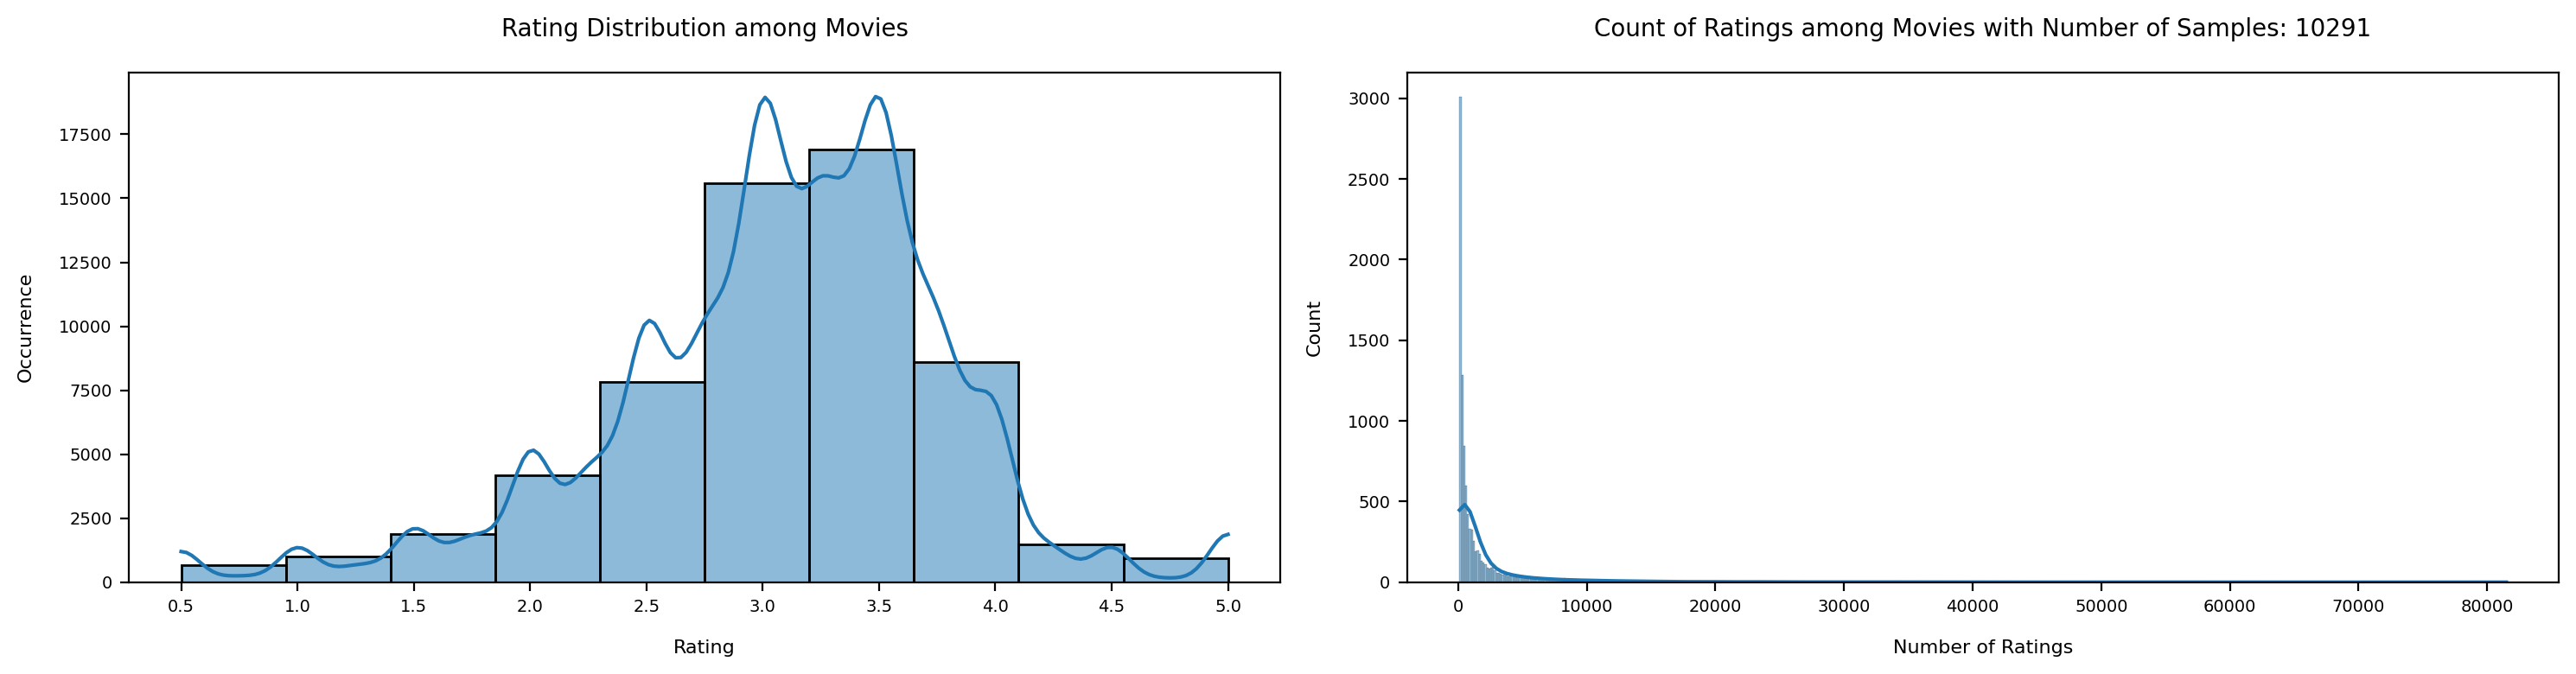

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
sns.histplot(x=df_movie_mean_count['mean'], kde=True, bins=len(np.arange(0.5, 5.5, 0.5)), ax=ax[0])
ax[0].set_title('Rating Distribution among Movies', pad=15, fontsize=10)
ax[0].set_xticks(np.arange(0.5, 5.5, 0.5))
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=7)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=7)
ax[0].set_xlabel('Rating', fontsize=8, labelpad=10);
ax[0].set_ylabel('Occurrence', fontsize=8, labelpad=10);


lower_threshold_movies, upper_threshold_movies = [100, 10 ** 10]
temp = df_movie_mean_count[(df_movie_mean_count['count'] > lower_threshold_movies) &
                          (df_movie_mean_count['count'] < upper_threshold_movies)]

sns.histplot(x=temp['count'], kde=True, ax=ax[1])
ax[1].set_title(f'Count of Ratings among Movies with Number of Samples: {len(temp)}', pad=15, fontsize=10)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=7)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=7)
ax[1].set_xlabel('Number of Ratings', fontsize=8, labelpad=10);
ax[1].set_ylabel('Count', fontsize=8, labelpad=10);

plt.tight_layout()

In [49]:
df_movie_mean_count.describe()

,mean,count
count,59047.000000,59047.000000
mean,3.071374,423.393144
std,0.739840,2477.885821
min,0.500000,1.000000
25%,2.687500,2.000000
50%,3.150000,6.000000
75%,3.500000,36.000000
max,5.000000,81491.000000


#### Recommendation Model Creation
- Choose any recommendation algorithm of your choice and develop a simple recommendation model

- In detail, document or comment your steps and reasons for choosing your approach

***Model Description:***

- In the model I will use collaborative filtering principles, focusing on item similarities based on user rating patterns.

- It involves calculating similarities between movies using the dot product of their rating vectors in a sparse matrix.

- It focuses on finding movies similar to a specific movie that a user has rated highly.

- This approach is advantageous because it directly leverages the collective rating patterns of all users to recommend movies, making it robust against the cold start problem for new users (to some extent) and providing recommendations based on the broad preferences reflected in the user-movie ratings matrix.

##### Similar Movies

In [50]:
def create_matrix(df):
    '''
    Converts a DataFrame of user-movie ratings into a sparse matrix and creates mappings 
    for user and movie IDs to their respective indices in the matrix.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with at least three columns: 'userId', 'movieId', 
      and 'rating'. Each row of the DataFrame represents a user's rating for a movie.

    Returns:
    - user_movie_mat (csr_matrix): A sparse matrix where rows represent movies, columns 
      represent users, and values represent ratings.
    - user_map (dict): A dictionary mapping original user IDs to their indices in the matrix.
    - movie_map (dict): A dictionary mapping original movie IDs to their indices in the matrix.
    - user_inv_map (dict): A dictionary mapping indices in the matrix back to original user IDs.
    - movie_inv_map (dict): A dictionary mapping indices in the matrix back to original movie IDs.

    The function first deep copies the input DataFrame to avoid modifying the original data. It 
    then calculates the unique count of users and movies to determine the dimensions of the 
    resulting sparse matrix. Mappings between original IDs and their corresponding indices in 
    the matrix are created to facilitate conversion. Finally, it constructs the sparse matrix 
    using ratings and the calculated indices, ensuring efficient storage and manipulation of 
    potentially large datasets.
    '''
    df = df.copy(deep=True)

    n_rows = df['userId'].nunique()
    n_columns = df['movieId'].nunique()

    user_map = dict(zip(df['userId'].unique(), list(range(n_rows))))
    user_inv_map = {value: key for key, value in user_map.items()}

    movie_map = dict(zip(df['movieId'].unique(), list(range(n_columns))))
    movie_inv_map = {value: key for key, value in movie_map.items()}

    user_idx = [user_map[i] for i in df['userId']]
    movie_idx = [movie_map[i] for i in df['movieId']]

    user_movie_mat = csr_matrix((df["rating"], (movie_idx, user_idx)), shape=(n_columns, n_rows))
    
    return user_movie_mat, user_map, movie_map, user_inv_map, movie_inv_map

user_movie_mat, user_encoder, movie_encoder, user_decoder, movie_decoder = create_matrix(dfs_dict['ratings'])

In [51]:
def get_similar_movies(movie_id, X, k, metric='cosine'):
    '''
    Finds and returns the IDs of k movies similar to the given movie_id, based on the
    cosine similarity of their feature vectors in the matrix X.

    Parameters:
    - movie_id: The ID of the movie for which to find similar movies.
    - X (csr_matrix): The feature matrix where each row corresponds to a movie, and
      columns represent features of these movies.
    - k (int): The number of similar movies to find.
    - movie_encoder (dict): A dictionary mapping movie IDs to their corresponding
      index in the matrix X.
    - movie_decoder (dict): A dictionary mapping indices in the matrix X back to
      movie IDs.
    - metric (str, optional): The distance metric to use for finding nearest neighbors.
      Default is 'cosine'.

    Returns:
    - list: A list of movie IDs representing the k most similar movies to the given
      movie_id. The list is empty if movie_id is not found in movie_encoder.

    Note:
    - The function assumes that movie_id is present in the movie_encoder dictionary.
      If not, it returns an empty list.
    - The returned list does not include the given movie_id.
    '''
    if movie_id not in movie_encoder:
        return []

    movie_idx = movie_encoder[movie_id]
    movie_vector = X[movie_idx].reshape(1, -1)  

    kNN = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric=metric)
    kNN.fit(X)
    neighbours = kNN.kneighbors(movie_vector, return_distance=False)[0]

    return [movie_decoder[idx] for idx in neighbours[1:]]


df_movie_titles = dfs_dict['movies'].drop(columns=['genres']).set_index('movieId')

movie_id = 1

similar_ids = get_similar_movies(movie_id, user_movie_mat, k=10)
movie_title = df_movie_titles.loc[movie_id, 'title']

print(f"Since you already watched '{movie_title}': \n")

your_top_recommendations = {
    idx: df_movie_titles.loc[idx_movie, 'title']
    for idx, idx_movie in enumerate(similar_ids)
}
pd.Series(your_top_recommendations)

Since you already watched 'Toy Story (1995)': 



0            Star Wars: Episode IV - A New Hope (1977)
1                                   Toy Story 2 (1999)
2                            Back to the Future (1985)
3                                  Forrest Gump (1994)
4                                 Jurassic Park (1993)
5    Star Wars: Episode VI - Return of the Jedi (1983)
6                 Independence Day (a.k.a. ID4) (1996)
7                                Lion King, The (1994)
8                                       Aladdin (1992)
9    Star Wars: Episode V - The Empire Strikes Back...
dtype: object

##### Movies For User

I propose a recommendation strategy that I would call the *"90th Percentile Strategy."*. I want the model to focus not solely on the top-rated movies but expanding to consider a broader spectrum of highly rated content.

The core idea is simple: instead of relying on the absolute highest-rated movies, model delves into the top 10% of a user’s ratings. By calculating the 90th percentile of user ratings, model identifies a threshold that marks their highly favored movies. A movie is then randomly selected from this elite subset to serve as the basis for finding similar films.

This strategy brings several key advantages:

- *Diversification*: It widens the array of recommendations, presenting users with options they are likely to enjoy but might not have discovered on their own.

- *Enhanced Personalization*: Acknowledging the range within a user's top-rated movies allows for a more nuanced understanding of their preferences, leading to better-tailored recommendations.

- *Increased Engagement*: By offering a varied set of suggestions, users are encouraged to explore new genres and titles, potentially finding new favorites and deepening their connection with the platform.

In essence, the *"90th Percentile Strategy"* is about embracing the diversity of user preferences and the richness of their interactions with movies. 

In [52]:
def get_recommendation_for_user(user_id, X, k=10):
    df_for_one_user = dfs_dict['ratings'][dfs_dict['ratings']['userId'] == user_id]
    if df_for_one_user.empty:
        print(f'Unfortunately, the user with ID {user_id} does not exist')
        return 

    threshold = np.percentile(df_for_one_user['rating'], 90)
    
    top_rated_movies = df_for_one_user[df_for_one_user['rating'] >= threshold]
    
    if not top_rated_movies.empty:
        movie_id = top_rated_movies.sample(n=1)['movieId'].iloc[0]
    else:
        print(f"No movies found above the 90th percentile for user {user_id}")
        return

    similar_ids = get_similar_movies(movie_id, X, k)
    movie_title = df_movie_titles.loc[movie_id, 'title']
    
    print(f"Since you already watched {movie_title}, these can be interesting for you:\n")
    for idx in similar_ids:
        print(df_movie_titles.loc[idx, 'title'])



user_id = 1
get_recommendation_for_user(user_id, user_movie_mat)

Since you already watched Dolls (2002), these can be interesting for you:

Kikujiro (Kikujirô no natsu) (1999)
Sonatine (Sonachine) (1993)
Fireworks (Hana-bi) (1997)
3-Iron (Bin-jip) (2004)
Spring, Summer, Fall, Winter... and Spring (Bom yeoreum gaeul gyeoul geurigo bom) (2003)
2046 (2004)
Blind Swordsman: Zatoichi, The (Zatôichi) (2003)
Last Life in the Universe (Ruang rak noi nid mahasan) (2003)
In the Mood For Love (Fa yeung nin wa) (2000)
Sympathy for Mr. Vengeance (Boksuneun naui geot) (2002)


### Ideas to improve Recommendations

#### Idea 1

1) ***Step 1: Analyzing Genre Preferences***

The journey begins with constructing a genre-wise pivot table that meticulously maps users against the genres of movies they've rated. This pivot table serves as a cornerstone, enabling us to:

- Quantitatively assess the frequency of genres each user engages with.
- Rank these genres to identify a hierarchy of preferences for every user.

The essence of this step is to uncover the genres that resonate most with our users, laying a foundational understanding that guides the recommendation process.

2) ***Step 2: Tailored Recommendations via kNN***

Leveraging the insights gained, our recommendation engine, powered by the k-Nearest Neighbors (kNN) algorithm, expands its horizon to fetch a broader selection of movies.The idea is:

- Ensure the inclusion of at least 3-5 movies from the user's top genre preference, adding 2-3 from their second favorite, and 1-2 from the third. This selection strategy not only honors the user's established tastes but also sprinkles in a diverse mix of genres to enrich their viewing experience.

In [53]:
df_movie_rating = pd.merge(dfs_dict['ratings'], dfs_dict['movies'], on='movieId', how='left')[['userId', 'genres']]
df_movie_rating

,userId,genres
0,1,Comedy|Crime|Drama|Thriller
1,1,Drama
2,1,Drama
3,1,Comedy|Drama|War
4,1,Comedy|Musical|Romance
...,...,...
25000090,162541,Animation|Children|Drama
25000091,162541,Animation|Comedy
25000092,162541,Children|Comedy
25000093,162541,Action|Crime|Drama|IMAX


In [54]:
def genre_popularity_among_users(df):
    """
    Computes genre popularity and ranking among users from a DataFrame.

    This function takes a DataFrame 'df' with columns including 'userId', 'genres', and movie ratings. It calculates
    the popularity (count of ratings) of each genre per user and ranks genres based on their popularity for each user.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing user IDs, genres, and movie ratings.

    Returns:
    - tuple of pd.DataFrame: Two pivot tables. The first contains counts of genre ratings per user, and the second
      contains rank of genres per user based on their popularity.

    Notes:
    - This function is computationally expensive. It may require significant processing time for large datasets.
    """
    df = df.copy(deep=True)
    df['genres'] = df['genres'].str.split('|')
    df_movie_rating_exploded = df.explode('genres')
    genre_popularity = df_movie_rating_exploded.groupby(['userId', 'genres']).size().reset_index(name='count').sort_values(['userId', 'count'], ascending=[True, False])

    pivot_table_count = genre_popularity.pivot_table(index='userId', columns='genres', values='count', fill_value=0)

    genre_popularity['rank'] = genre_popularity.groupby('userId')['count'].rank(method='dense', ascending=False)
    genre_rank = genre_popularity[['userId', 'genres', 'rank']].sort_values(by=['userId', 'rank'])
    pivot_table_rank = genre_rank.pivot_table(index='userId', columns='genres', values='rank', fill_value=None)
    
    return pivot_table_count, pivot_table_rank

pivot_table_count, pivot_table_rank = genre_popularity_among_users(df_movie_rating)

In [55]:
pivot_table_count

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0,4,11,2,3,23,8,1,53,5,1,1,0,5,4,18,5,5,5,1
2,0,66,75,17,25,63,18,0,91,29,0,3,6,11,8,34,28,30,15,5
3,1,334,198,50,48,176,132,3,232,78,5,45,81,6,60,60,224,239,26,8
4,0,145,114,31,28,81,37,5,49,39,0,10,41,7,18,10,85,56,9,9
5,0,18,21,4,9,49,14,0,45,8,0,3,3,7,7,20,11,24,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,0,18,16,7,13,59,8,1,34,10,0,5,0,12,3,34,5,15,2,1
162538,0,25,27,10,10,76,14,0,78,15,0,11,8,6,7,65,14,22,10,2
162539,0,18,15,3,2,13,4,0,27,3,3,1,0,1,3,12,11,9,21,0


In [56]:
pivot_table_rank

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,NaN,7.0,4.0,9.0,8.0,2.0,5.0,10.0,1.0,6.0,10.0,10.0,NaN,6.0,7.0,3.0,6.0,6.0,6.0,10.0
2,NaN,3.0,2.0,11.0,9.0,4.0,10.0,NaN,1.0,7.0,NaN,17.0,15.0,13.0,14.0,5.0,8.0,6.0,12.0,16.0
3,19.0,1.0,5.0,11.0,12.0,6.0,7.0,18.0,3.0,9.0,17.0,13.0,8.0,16.0,10.0,10.0,4.0,2.0,14.0,15.0
4,NaN,1.0,2.0,10.0,11.0,4.0,9.0,16.0,6.0,8.0,NaN,13.0,7.0,15.0,12.0,13.0,3.0,5.0,14.0,14.0
5,NaN,6.0,4.0,13.0,9.0,1.0,7.0,NaN,2.0,10.0,NaN,14.0,14.0,11.0,11.0,5.0,8.0,3.0,15.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,NaN,3.0,4.0,10.0,6.0,1.0,9.0,14.0,2.0,8.0,NaN,11.0,NaN,7.0,12.0,2.0,11.0,5.0,13.0,14.0
162538,NaN,5.0,4.0,10.0,10.0,2.0,8.0,NaN,1.0,7.0,NaN,9.0,11.0,13.0,12.0,3.0,8.0,6.0,10.0,14.0
162539,NaN,3.0,4.0,10.0,11.0,5.0,9.0,NaN,1.0,10.0,10.0,12.0,NaN,12.0,10.0,6.0,7.0,8.0,2.0,NaN


In [57]:
pivot_table_rank_temp = pivot_table_rank.copy(deep=True)

In [58]:
pivot_table_rank_temp

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,NaN,7.0,4.0,9.0,8.0,2.0,5.0,10.0,1.0,6.0,10.0,10.0,NaN,6.0,7.0,3.0,6.0,6.0,6.0,10.0
2,NaN,3.0,2.0,11.0,9.0,4.0,10.0,NaN,1.0,7.0,NaN,17.0,15.0,13.0,14.0,5.0,8.0,6.0,12.0,16.0
3,19.0,1.0,5.0,11.0,12.0,6.0,7.0,18.0,3.0,9.0,17.0,13.0,8.0,16.0,10.0,10.0,4.0,2.0,14.0,15.0
4,NaN,1.0,2.0,10.0,11.0,4.0,9.0,16.0,6.0,8.0,NaN,13.0,7.0,15.0,12.0,13.0,3.0,5.0,14.0,14.0
5,NaN,6.0,4.0,13.0,9.0,1.0,7.0,NaN,2.0,10.0,NaN,14.0,14.0,11.0,11.0,5.0,8.0,3.0,15.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,NaN,3.0,4.0,10.0,6.0,1.0,9.0,14.0,2.0,8.0,NaN,11.0,NaN,7.0,12.0,2.0,11.0,5.0,13.0,14.0
162538,NaN,5.0,4.0,10.0,10.0,2.0,8.0,NaN,1.0,7.0,NaN,9.0,11.0,13.0,12.0,3.0,8.0,6.0,10.0,14.0
162539,NaN,3.0,4.0,10.0,11.0,5.0,9.0,NaN,1.0,10.0,10.0,12.0,NaN,12.0,10.0,6.0,7.0,8.0,2.0,NaN


Implement the results of such a transformation into *get_recommendation_for_user* and extent it with new functions.

#### Idea 2 

**In the exploratory data analysis (EDA) phase, several intriguing patterns emerged that warrant careful consideration for refining the recommendation system:**

- *Extreme Rating Behavior*: 
A subset of users exhibit extreme rating behaviors, consistently assigning either perfect scores (5.0) or the lowest possible score (0.5) across the board, regardless of the movie. This pattern raises questions about the reliability and meaningfulness of such ratings. To enhance the robustness of our model, it may be beneficial to consider filtering out these users from the dataset.

- *High-Frequency Rating Activity*: 
Attention should also be directed towards users who rate a large volume of movies within a short timeframe. This unusual activity pattern merits further investigation to understand its underlying causes. Identifying whether these behaviors are indicative of automated systems or genuine user engagement is crucial for maintaining the integrity of the recommendation system.

- *Excessive Number of Ratings*: 
The credibility of ratings from users who have reviewed an exceptionally high number of movies (e.g., over 30,000) also comes into question. Such outliers could potentially skew the recommendation algorithm. Evaluating the impact of excluding these users on the system's performance and recommendations' quality might be necessary.
These insights from the EDA underscore the importance of data quality and user behavior in developing effective recommendation systems. By addressing these issues, we can aim to enhance the accuracy and trustworthiness of the recommendations provided to users.


#### Idea 3

***We can change the approach on the following one:***

- Strategic process centered around the intricate "user-movie" rating matrix. Initially, we harness the power of cosine similarity to meticulously identify the top-N users whose movie rating patterns closely mirror those of our focal user. This step is pivotal in pinpointing a cohort of users with aligning tastes and preferences.

- Upon establishing this curated group of closely aligned users, our strategy advances by filtering their movie interactions to spotlight the top 10 percent of movies, based on their ratings. This selection process is both selective and strategic, ensuring that only the most highly regarded movies are considered for the next phase.

- The refinement continues as we sift through this elite list of movies, purposefully excluding any titles already familiar to our focal user. This ensures that our recommendations are both fresh and relevant, tailored to introduce the user to new cinematic experiences they are predisposed to enjoy.

- With this meticulously curated list of movies, the final leg of our journey involves a sophisticated similarity analysis. By evaluating how closely these movies resemble those our user has positively rated in the past, we're able to offer a selection of recommendations that are not only novel but also resonantly aligned with the user's established preferences.

This methodological blend of user similarity mapping, selective filtering, and targeted similarity analysis represents a holistic and user-centric approach to recommendation systems, designed to enchant users with discoveries that resonate on a deeply personal level.